In [1]:
# Import TensorFlow and NumPy
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
# Set data type
DTYPE='float64'
tf.keras.backend.set_floatx(DTYPE)


S_range = [0, 160]
t_range = [0, 1]
K= 40
sigma = 0.2
r =0.05
T = 1
gs = lambda x: np.fmax(x-K, 0)



# Define residual of the PDE
def fun_r(t, x, u, u_t, u_x, u_xx):
    return u_t + r * x * u_x + ((sigma**2)/2) * (x**2) * u_xx - r * u

121.47222329116713


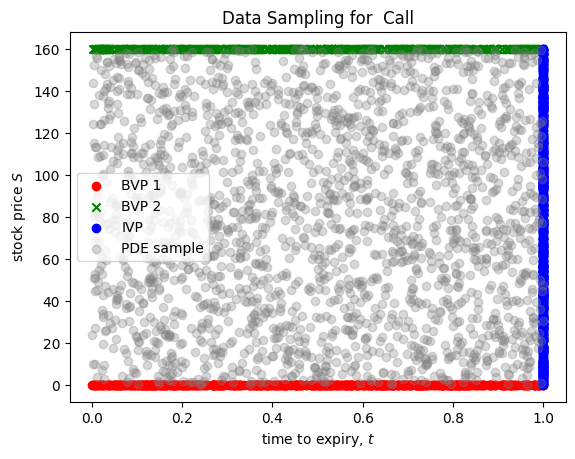

In [2]:

#pde samples
def get_diff_data(n):
    X = np.concatenate([np.random.uniform(*t_range, (n, 1)),
                        np.random.uniform(*S_range, (n, 1))], axis=1)
    y = np.zeros((n, 1)) #price
    return X, y

#initial values
def get_ivp_data(n):
    X = np.concatenate([np.ones((n, 1)), #all at expiry time
                    np.random.uniform(*S_range, (n, 1))], axis=1)
    y = gs(X[:, 1]).reshape(-1, 1)

    return X, y


#boundary values
def get_bvp_data(n):
    X1 = np.concatenate([np.random.uniform(*t_range, (n, 1)),
                        S_range[0] * np.ones((n, 1))], axis=1)
    y1 = np.zeros((n, 1))

    X2 = np.concatenate([np.random.uniform(*t_range, (n, 1)),
                        S_range[-1] * np.ones((n, 1))], axis=1)
    y2 = (S_range[-1] - K*np.exp(-r*(T-X2[:, 0].reshape(-1)))).reshape(-1, 1)

    return X1, y1, X2, y2

# Set number of data points
N_0 = 500
N_b = 500
N_r = 2000

bvp_x1,bvp_y1,bvp_x2,bvp_y2 = get_bvp_data(N_b)
ivp_x1,ivp_y1 = get_ivp_data(N_0)
diff_x1,diff_y1 = get_diff_data(N_r)
plt.scatter(bvp_x1[:,0],bvp_x1[:,1], label= "BVP 1", color = "red",marker="o")
plt.scatter(bvp_x2[:,0],bvp_x2[:,1], label= "BVP 2", color = "green",marker="x")
plt.scatter(ivp_x1[:,0],ivp_x1[:,1], label= "IVP", color = "blue")
plt.scatter(diff_x1[:,0],diff_x1[:,1], label= "PDE sample", color = "grey", alpha = 0.3)
plt.xlabel("time to expiry, $t$")
plt.ylabel("stock price $S$")
plt.title("Data Sampling for  Call")
plt.legend()

#########
# Collect boundary and inital data in lists


X_data = [ivp_x1, bvp_x1,bvp_x2]
u_data = [ivp_y1, bvp_y1,bvp_y2]
X_r =diff_x1


X_data = tf.convert_to_tensor([tf.convert_to_tensor(data, dtype=tf.float64) for data in X_data])
u_data = tf.convert_to_tensor([tf.convert_to_tensor(data, dtype=tf.float64) for data in u_data])
X_r = tf.convert_to_tensor( X_r)

print(S_range[-1] - K*np.exp(-r*(T-0.25)))

In [3]:
def init_model(num_hidden_layers=8, num_neurons_per_layer=20):
    # Initialize a feedforward neural network
    model = tf.keras.Sequential()

    # Input is two-dimensional (time + one spatial dimension)
    model.add(tf.keras.Input(2))

    # Introduce a scaling layer to map input to [lb, ub]
    scaling_layer = tf.keras.layers.Lambda(
                lambda x: 2.0*(x - lb)/(ub - lb) - 1.0)
    model.add(scaling_layer)

    # Append hidden layers
    for _ in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons_per_layer,
            activation=tf.keras.activations.get('tanh'),
            kernel_initializer='glorot_normal'))

    # Output is one-dimensional
    model.add(tf.keras.layers.Dense(1))

    return model

## fait2.png : 5*80

def init_model2(num_hidden_layers=8, num_neurons_per_layer=100):
    # Initialize a feedforward neural network
    model = tf.keras.Sequential()

    # Input is two-dimensional (time + one spatial dimension)
    model.add(tf.keras.Input(2))

    # Introduce a scaling layer to map input to [lb, ub]
    scaling_layer = tf.keras.layers.Lambda(
                lambda x: 2.0*(x - lb)/(ub - lb) - 1.0)
    #model.add(scaling_layer)

    # Append first hidden layer
    model.add(tf.keras.layers.Dense(num_neurons_per_layer,
            activation=tf.keras.activations.get('leaky_relu'),
            kernel_initializer='glorot_normal'))

    # Append remaining hidden layers
    for _ in range(num_hidden_layers - 1):
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Dense(num_neurons_per_layer,
            activation=tf.keras.activations.get('tanh'),
            kernel_initializer='glorot_normal'))

    # Output is one-dimensional
    model.add(tf.keras.layers.Dense(1))

    return model


In [4]:
def get_r(model, X_r):

    # A tf.GradientTape is used to compute derivatives in TensorFlow
    with tf.GradientTape(persistent=True) as tape:
        # Split t and x to compute partial derivatives
        t, x = X_r[:, 0:1], X_r[:,1:2]

        # Variables t and x are watched during tape
        # to compute derivatives u_t and u_x
        tape.watch(t)
        tape.watch(x)

        # Determine residual
        u = model(tf.stack([t[:,0], x[:,0]], axis=1))

        # Compute gradient u_x within the GradientTape
        # since we need second derivatives
        u_x = tape.gradient(u, x)

    u_t = tape.gradient(u, t)
    u_xx = tape.gradient(u_x, x)

    del tape

    return fun_r(t, x, u, u_t, u_x, u_xx)

def compute_loss(model, X_r, X_data, u_data):

    # Compute phi^r
    r = get_r(model, X_r)
    phi_r = tf.reduce_mean(tf.square(r))

    # Initialize loss
    loss = phi_r

    # Add phi^0 and phi^b to the loss
    for i in range(len(X_data)):
      if i == 0:
          u_pred = model(X_data[i])
          loss += tf.reduce_mean(tf.square(u_data[i] - u_pred))


    return loss

def get_grad(model, X_r, X_data, u_data):

    with tf.GradientTape(persistent=True) as tape:
        # This tape is for derivatives with
        # respect to trainable variables
        tape.watch(model.trainable_variables)
        loss = compute_loss(model, X_r, X_data, u_data)

    g = tape.gradient(loss, model.trainable_variables)
    del tape

    return loss, g


In [5]:
# Initialize model aka u_\theta
model = init_model2()

# We choose a piecewise decay of the learning rate, i.e., the
# step size in the gradient descent type algorithm
# the first 1000 steps use a learning rate of 0.01
# from 1000 - 3000: learning rate = 0.001
# from 3000 onwards: learning rate = 0.0005

#lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000],[1e-2,1e-3,5e-4])

# Choose the optimizer
optim = tf.keras.optimizers.Adam(learning_rate=7e-5)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               300       
                                                                 
 batch_normalization (Batch  (None, 100)               400       
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 batch_normalization_1 (Bat  (None, 100)               400       
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 batch_normalization_2 (Bat  (None, 100)               4

In [6]:
from time import time

# Define one training step as a TensorFlow function to increase speed of training
@tf.function
def train_step():
    # Compute current loss and gradient w.r.t. parameters
    loss, grad_theta = get_grad(model, X_r, X_data, u_data)

    # Perform gradient descent step
    optim.apply_gradients(zip(grad_theta, model.trainable_variables))

    return loss


# Number of training epochs
N = 0
hist = []

# train more to reach a better loss
# Start timer
t0 = time()

while True:

    loss = train_step()

    # Append current loss to hist
    hist.append(loss.numpy())
    if (loss<1.3e-02):
      print(N)
      break

    # Output current loss after 50 iterates
    if N%50 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(N,loss))
    N+=1

# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

It 00000: loss = 3.35359079e+03
It 00050: loss = 2.93632301e+03
It 00100: loss = 2.72563691e+03
It 00150: loss = 2.57861994e+03
It 00200: loss = 2.46709183e+03
It 00250: loss = 2.39040738e+03
It 00300: loss = 2.33486728e+03
It 00350: loss = 2.29082897e+03
It 00400: loss = 2.25356205e+03
It 00450: loss = 2.22068095e+03
It 00500: loss = 2.19065528e+03
It 00550: loss = 2.16263081e+03
It 00600: loss = 2.13605189e+03
It 00650: loss = 2.11059291e+03
It 00700: loss = 2.08596287e+03
It 00750: loss = 2.06207639e+03
It 00800: loss = 2.03876880e+03
It 00850: loss = 2.01599851e+03
It 00900: loss = 1.99367852e+03
It 00950: loss = 1.97177635e+03
It 01000: loss = 1.95028540e+03
It 01050: loss = 1.92902821e+03
It 01100: loss = 1.90814381e+03
It 01150: loss = 1.88757214e+03
It 01200: loss = 1.86724521e+03
It 01250: loss = 1.84720898e+03
It 01300: loss = 1.82743426e+03
It 01350: loss = 1.80787434e+03
It 01400: loss = 1.78857576e+03
It 01450: loss = 1.76953239e+03
It 01500: loss = 1.75068562e+03
It 01550

In [ ]:
from scipy.stats import norm

def black_scholes_call(S, K, r, sigma, T, t):
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*(T - t))/(sigma*np.sqrt(T - t))
    d2 = d1 - sigma*np.sqrt(T - t)
    return S*norm.cdf(d1) - K*np.exp(-r*(T - t))*norm.cdf(d2)


<ipython-input-26-947d4fbfe68f>:4: RuntimeWarning: divide by zero encountered in log
  d1 = (np.log(S/K) + (r + 0.5*sigma**2)*(T - t))/(sigma*np.sqrt(T - t))


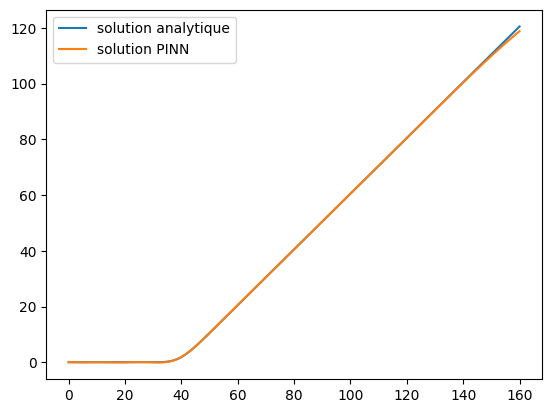

In [ ]:

ss = np.linspace(0,160,500)
tt = np.array([0.75]*ss.shape[0])
pred = []
for s,t in zip(ss,tt) :
    pred.append(model(np.array([[t, s]])).numpy().flatten()[0])


bs = black_scholes_call(ss,K,r,sigma,T,tt)

plt.plot(ss,bs,label = 'solution analytique')
plt.plot(ss,pred,label ='solution PINN')
plt.legend()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculer l'erreur quadratique moyenne (RMSE)
rmse = np.sqrt(mean_squared_error(bs, pred))

# Calculer l'erreur absolue moyenne (MAE)
mae = mean_absolute_error(bs, pred)

print("Erreur quadratique moyenne (RMSE) :", rmse)
print("Erreur absolue moyenne (MAE) :", mae)


Erreur quadratique moyenne (RMSE) : 1.8015970447577716
Erreur absolue moyenne (MAE) : 0.6444839976419856
